###Importing Modules

In [ ]:
# !pip install cmake

# !git clone https://github.com/davisking/dlib.git
# %cd dlib
# !mkdir build
# %cd build
# !cmake .. -DDLIB_USE_CUDA=0 -DUSE_AVX_INSTRUCTIONS=1
# !cmake --build .
# %cd ..
# !python setup.py install --no DLIB_USE_CUDA

In [3]:
!pip install imutils

In [23]:
import cv2, dlib, os, numpy as np
from scipy.spatial import distance
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import imutils
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import dlib

In [5]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

face_detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

--2025-04-11 09:28:02--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-04-11 09:28:02--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  17.0MB/s    in 4.5s    

2025-04-11 09:28:08 (13.7 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



###Uploading API Key

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sanikanarmitwar","key":"c4341df17f27b7a2917cc8db27ce2b64"}'}

###Loading Dataset

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd -p /content
!unzip -o /content/driver-drowsiness-dataset-ddd.zip -d /content/ddd_dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/ddd_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0082.png  
  inflating: /content/ddd_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0083.png  
  inflating: /content/ddd_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0084.png  
  inflating: /content/ddd_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0085.png  
  inflating: /content/ddd_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0086.png  
  inflating: /content/ddd_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0087.png  
  inflating: /content/ddd_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0088.png  
  inflating: /content/ddd_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0089.png  
  inflating: /content/ddd_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0090.png  
  inflating: /content/ddd_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0091.png  
  inflating: /content/ddd_dataset/Driver Drowsiness Dataset

###EAR and MAR Calculation

In [6]:
def calculate_ear(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    return (A + B) / (2.0 * C)

def calculate_mar(mouth):
    A = distance.euclidean(mouth[1], mouth[7])
    B = distance.euclidean(mouth[2], mouth[6])
    C = distance.euclidean(mouth[3], mouth[5])
    D = distance.euclidean(mouth[0], mouth[4])
    return (A + B + C) / (3.0 * D)

In [7]:
def extract_ear_mar(frame_path):
    image = cv2.imread(frame_path)
    if image is None: return None, None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_detector(gray)
    if len(faces) == 0: return None, None

    for face in faces:
        shape = predictor(gray, face)
        coords = np.array([[p.x, p.y] for p in shape.parts()])
        leftEye = coords[42:48]
        rightEye = coords[36:42]
        mouth = coords[60:68]

        ear = (calculate_ear(leftEye) + calculate_ear(rightEye)) / 2.0
        mar = calculate_mar(mouth)
        return ear, mar
    return None, None

###Implementation

In [8]:
DATASET_PATH = "/content/ddd_dataset/Driver Drowsiness Dataset (DDD)"
categories = ['Drowsy', 'Non Drowsy']
video_groups = defaultdict(list)

for cat in categories:
    folder = os.path.join(DATASET_PATH, cat)
    for fname in os.listdir(folder):
        if fname.endswith(".jpg") or fname.endswith(".png"):
            prefix = fname[0]  # 'a', 'b', etc.
            video_groups[(cat, prefix)].append(os.path.join(folder, fname))

In [9]:
def extract_features(frames):
    ear_list, mar_list = [], []
    blink_count = 0
    prev_closed = False
    total_frames = len(frames)
    processed_frames = 0

    for f in sorted(frames):
        ear, mar = extract_ear_mar(f)
        if ear is not None:
            processed_frames += 1
            ear_list.append(ear)
            mar_list.append(mar)

            is_closed = ear < 0.25
            if not prev_closed and is_closed:
                blink_count += 1
            prev_closed = is_closed


    if not ear_list:
        return None

    ears = np.array(ear_list)
    mars = np.array(mar_list)

    perclos = np.mean(ears < 0.25) * 100
    mcd = np.mean(ears[ears < 0.25]) if np.any(ears < 0.25) else 0
    aol = np.mean(ears[ears >= 0.25]) if np.any(ears >= 0.25) else 0
    ov = np.std(ears[ears >= 0.25]) if np.any(ears >= 0.25) else 0
    cv = np.std(ears[ears < 0.25]) if np.any(ears < 0.25) else 0

    return {
        'PERCLOS': perclos,
        'MCD': mcd,
        'AOL': aol,
        'BF': blink_count/processed_frames,
        'OV': ov,
        'CV': cv,
        'MAR_mean': np.mean(mars),
        'MAR_std': np.std(mars)
    }




In [10]:
results = []
for (label, prefix), frames in tqdm(video_groups.items()):
    feats = extract_features(frames)
    if feats:
        feats['Label'] = label
        feats['VideoPrefix'] = prefix
        results.append(feats)

df = pd.DataFrame(results)
df.to_csv("driver_drowsiness_features.csv", index=False)
df.head()

100%|██████████| 50/50 [09:02<00:00, 10.85s/it]


,PERCLOS,MCD,AOL,BF,OV,CV,MAR_mean,MAR_std,Label,VideoPrefix
0,99.785867,0.196519,0.250769,0.004283,0.000000,0.022969,0.016667,0.006339,Drowsy,J
1,3.614458,0.224428,0.428572,0.033735,0.045969,0.008351,0.174960,0.057794,Drowsy,F
2,98.145859,0.150487,0.280133,0.011125,0.024210,0.027236,0.017349,0.008047,Drowsy,P
3,100.000000,0.152168,0.000000,0.022727,0.000000,0.036262,0.100219,0.090163,Drowsy,M
4,32.649891,0.202888,0.347321,0.071140,0.059610,0.036518,0.037167,0.031012,Drowsy,Z


In [11]:
le = LabelEncoder()
df['Label_encoded'] = le.fit_transform(df['Label'])

In [12]:
# labels (Drowsy = 1, Non Drowsy = 0)
le = LabelEncoder()
df['Label_encoded'] = le.fit_transform(df['Label'])

X = df.drop(columns=['Label', 'VideoPrefix', 'Label_encoded'])
y = df['Label_encoded']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

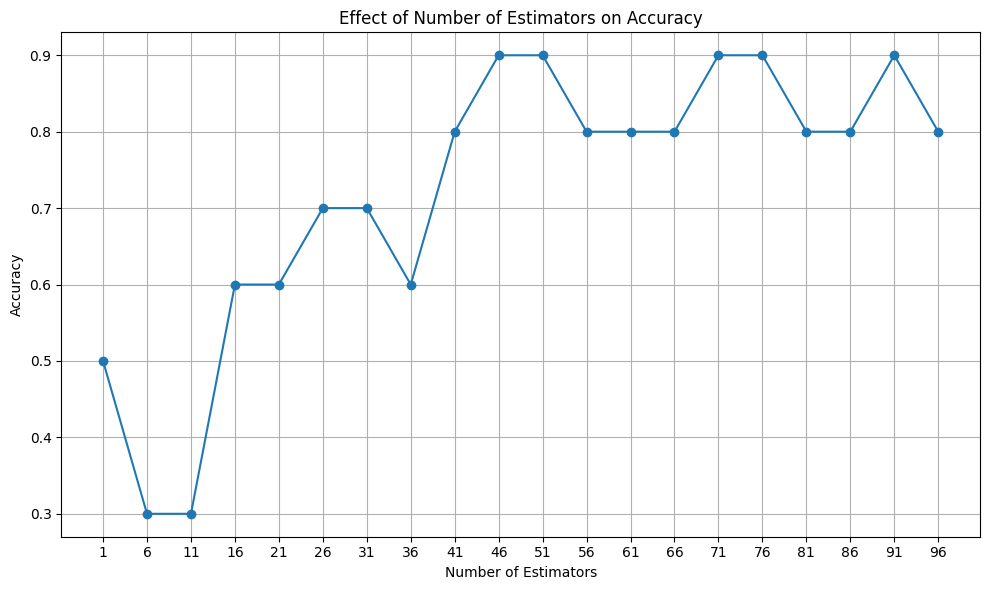

In [20]:
estimator_range = range(1, 100, 5)
accuracies = []

for n in estimator_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

plt.figure(figsize=(10, 6))
plt.plot(estimator_range, accuracies, marker='o', linestyle='-')
plt.title('Effect of Number of Estimators on Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(estimator_range)
plt.tight_layout()
plt.show()

In [21]:
rf = RandomForestClassifier(n_estimators=51, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Random Forest Accuracy: 0.9
              precision    recall  f1-score   support

      Drowsy       0.80      1.00      0.89         4
  Non Drowsy       1.00      0.83      0.91         6

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10



In [22]:
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

SVM Accuracy: 0.9
              precision    recall  f1-score   support

      Drowsy       1.00      0.75      0.86         4
  Non Drowsy       0.86      1.00      0.92         6

    accuracy                           0.90        10
   macro avg       0.93      0.88      0.89        10
weighted avg       0.91      0.90      0.90        10

